In [ ]:
pwd

In [71]:
import requests
import json
import time
import os
from pprint import pprint

import pandas as pd
pd.set_option('display.precision', 1)
import warnings
warnings.filterwarnings("ignore", message=".*will drop timezone.*")

%matplotlib inline
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

%load_ext autoreload
%autoreload 2
from clean_convert import cleanup, convert_speed, order_columns
from zones import get_zones_for_id, build_week_summary

# import graphics programs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,6)}) # for all future plots

import sys
sys.executable

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/edwardterrell/opt/anaconda3/envs/mlml/bin/python'

In [2]:
from token_manager import get_valid_access_token
import requests

access_token = get_valid_access_token()
print("Using access token:", access_token)

# Make an authenticated API call
response = requests.get(
    'https://www.strava.com/api/v3/athlete',
    headers={'Authorization': f'Bearer {access_token}'}
)
print(response.json())

Access token expired. Refreshing...
Using access token: 2c945876da5e977ebc8dca48a9ba3b94cf933536
{'id': 723727, 'username': 'eterrell', 'resource_state': 2, 'firstname': 'Ed', 'lastname': 'Terrell', 'bio': '', 'city': 'Boulder', 'state': 'CO', 'country': 'United States', 'sex': 'M', 'premium': True, 'summit': True, 'created_at': '2012-07-05T00:04:09Z', 'updated_at': '2025-07-09T12:38:59Z', 'badge_type_id': 1, 'weight': 61.235, 'profile_medium': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/medium.jpg', 'profile': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/large.jpg', 'friend': None, 'follower': None}


In [80]:
# Reload dfs and confirm lengths
strava_df = pd.read_pickle("strava_data_2024.pkl")
strava_zone_df = pd.read_pickle("strava_zone_data_2024.pkl")

print(len(strava_df))
print(len(strava_zone_df))

4
4


### Recent activities only!

In [82]:
# Get activities from month start
start_date = int(time.mktime(time.strptime('2024-01-17', '%Y-%m-%d')))
end_date = int(time.mktime(time.strptime('2024-02-01', '%Y-%m-%d')))

url = "https://www.strava.com/api/v3/athlete/activities"
headers = {"Authorization": f"Bearer {access_token}"}
params = {
    "after": start_date,
    "per_page": 200,  # max per request
    "page": 1
}
activities = []

stop_fetching = False
while True:
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    if not data or stop_fetching:
        break
        
    for activity in data:
        activity_date = int(datetime.datetime.strptime(activity['start_date'], "%Y-%m-%dT%H:%M:%SZ").timestamp())

        #print(activity['start_date'])
        print(activity_date)
        if activity_date >= end_date:
            stop_fetching = True
            break
        if len(activities) >= 10:
            stop_fetching = True
            break

        activities.append(activity)
    params["page"] += 1


# Build out strava_df with only the necessary columns
recent_df = pd.DataFrame(activities)
cols_needed = ['id','name', 'distance', 'moving_time','total_elevation_gain', 'sport_type',
          'average_speed', 'average_heartrate','max_heartrate', 'suffer_score','start_date']
recent_df = recent_df.loc[:,cols_needed]
recent_df = recent_df.sort_values('start_date',ascending=False) 

new_activities_df = recent_df[~recent_df.id.isin(strava_df.id)].copy()
new_activities_df

1705507076
1705593057
1705681747
1705766710
1705851658
1705938085
1705939835
1706197554
1706283820
1706369359
1706454715


,id,name,distance,moving_time,total_elevation_gain,sport_type,average_speed,average_heartrate,max_heartrate,suffer_score,start_date
9,10639829371,"Calpe D3 Coastal loop: Xabia, Denia",113013.0,19037,1590.0,Ride,5.9,102.8,141.0,136.0,2024-01-27T08:29:19Z
8,10633308438,Calp D2 Pego - La Vall de Laguar - Coll de la ...,104691.0,17893,1806.0,Ride,5.9,103.0,141.0,134.0,2024-01-26T08:43:40Z
7,10626827285,Calp D1 Castell de Castells loop (via Xalo),85703.5,13785,1413.6,Ride,6.2,116.8,148.0,231.0,2024-01-25T08:45:54Z
6,10606866199,Tenerife D9 Packing day (Villaflor),60208.9,11421,1449.0,Ride,5.3,110.8,136.0,138.0,2024-01-22T09:10:35Z
5,12885780488,Morning Ride,1344.8,492,0.0,Ride,2.7,62.6,85.0,0.0,2024-01-22T08:41:25Z
4,10600329993,Tenerife D8 Churros and Leche-Leche,46565.9,9256,914.0,Ride,5.0,96.3,122.0,39.0,2024-01-21T08:40:58Z
3,10595406083,Tenerife D7 Teide from the north,98405.9,19782,2465.0,Ride,5.0,119.6,166.0,424.0,2024-01-20T09:05:10Z
2,10588186702,Tenerife D6 Arico (but no loop due to stormy c...,76229.6,13074,1294.8,Ride,5.8,105.0,146.0,103.0,2024-01-19T09:29:07Z
1,10582706259,Tenerife D5 Masca,85772.4,18539,2164.0,Ride,4.6,109.9,181.0,219.0,2024-01-18T08:50:57Z
0,10576769362,"Tenerife D4 El Teide loop, Inside the Caldera",121169.0,22536,2671.8,Ride,5.4,115.2,143.0,341.0,2024-01-17T08:57:56Z


In [85]:
if not new_activities_df.empty:
    # proceed with combining or processing

    new_activities_df = cleanup (new_activities_df)
    new_activities_df['converted_speed'] = new_activities_df.apply(convert_speed, axis=1)
    new_activities_df = order_columns(new_activities_df)
    
    strava_df = pd.concat ([new_activities_df, strava_df])
    #strava_df.head()

    # Recent zone data
    # Create a new_zone dataframe for recent activities
    cols = ['id', 'name', 'date', 'suffer_score','start_date']
    new_data = new_activities_df.loc[:,cols]
    new_zone_df = pd.DataFrame(new_data, columns=cols)
    new_zone_df
    
    zone = new_zone_df['id'].apply(lambda current_id: get_zones_for_id(current_id, access_token))
    zone.index = new_zone_df['id']
    
    # Add in summary zones: moderate and intense
    zone['moderate'] = zone[['Zone1', 'Zone2']].sum(axis=1)
    zone['intense'] = zone[['Zone3', 'Zone4', 'Zone5']].sum(axis=1)
    zone
    
    new_zone_df = pd.merge(new_zone_df, zone, left_on='id',right_index=True)
    new_zone_df
    
    # Get the Sunday start of the week for each date (time set to midnight)
    new_zone_df['week_start'] = new_zone_df['start_date'].dt.to_period('W-SUN').dt.start_time
    
    #new_zone_df.columns are now matched with strava_zone_df
    new_zone_df = pd.concat ([new_zone_df, strava_zone_df], axis=0)
    
    new_zone_df.head(5)
    # This drops weekly_ cols since they are all recalculated later
    only_cols = ['id', 'name', 'date', 'suffer_score', 'start_date', 'Zone1', 'Zone2',
           'Zone3', 'Zone4', 'Zone5', 'moderate', 'intense', 'week_start']
    new_zone_df = new_zone_df[only_cols]
    new_zone_df.head()
    
    # Temporarily sort ascending by week_start and date to compute cumulative sum correctly
    temp = new_zone_df.sort_values(['week_start', 'start_date'])
    
    # Calculate cumulative sum within each week for weekly_ cols
    cumulative_cols = ['intense', 'moderate', 'suffer_score']
    cumulative_sums = (
        temp
        .groupby('week_start')[cumulative_cols]
        .cumsum()
        .add_prefix('weekly_')  # rename columns if needed
    )
    # Add start_date column for reference
    cumulative_sums['start_date'] = temp['start_date']
    cumulative_sums = cumulative_sums.sort_values('start_date', ascending = False)
    cumulative_sums.head(3)

    strava_zone_df = pd.merge(new_zone_df,cumulative_sums, left_on ='start_date', right_on='start_date')
    week_summary = build_week_summary(strava_zone_df)
    week_summary.sort_values('week_start',ascending=False).head()
else:
    week_summary = build_week_summary(strava_zone_df)
    week_summary.sort_values('week_start',ascending=False).head()

Fetching zones for activity: 10639829371
Fetching zones for activity: 10633308438
Fetching zones for activity: 10626827285
Fetching zones for activity: 10606866199
Fetching zones for activity: 12885780488
Fetching zones for activity: 10600329993
Fetching zones for activity: 10595406083
Fetching zones for activity: 10588186702
Fetching zones for activity: 10582706259
Fetching zones for activity: 10576769362


### Historical strava data - select dates

In [28]:
# Get activities from Jan 1, 2025 onward
start_date = int(time.mktime(time.strptime('2024-01-01', '%Y-%m-%d')))
print (start_date)
end_date = int(time.mktime(time.strptime('2024-02-01', '%Y-%m-%d')))
print(end_date)

1704092400
1706770800


In [23]:
import datetime

In [43]:
url = "https://www.strava.com/api/v3/athlete/activities"
headers = {"Authorization": f"Bearer {access_token}"}
params = {
    "after": start_date,
    "per_page": 30,  # max per request
    "page": 1
}
activities = []
stop_fetching = False
while True:
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    if not data or stop_fetching:
        break
        
    for activity in data:
        activity_date = int(datetime.datetime.strptime(activity['start_date'], "%Y-%m-%dT%H:%M:%SZ").timestamp())

        #print(activity['start_date'])
        print(activity_date)
        if activity_date >= end_date:
            stop_fetching = True
            break
        if len(activities) >= 10:
            stop_fetching = True
            break

        activities.append(activity)
    params["page"] += 1

1704159018
1704250800
1704252397
1704329341
1704425918
1704589620
1705076219
1705253610
1705333455
1705425561
1705507076


In [44]:
df = pd.DataFrame(activities)
df.head()

,resource_state,athlete,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,workout_type,...,pr_count,total_photo_count,has_kudoed,average_temp,average_watts,device_watts,kilojoules,average_heartrate,max_heartrate,suffer_score
0,2,"{'id': 723727, 'resource_state': 1}",Steamboat walk,6295.5,5143,6865,32.0,Run,Run,0.0,...,0,5,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,"{'id': 723727, 'resource_state': 1}",Warmup,4828.0,5280,5280,0.0,Run,Run,NaN,...,0,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"{'id': 723727, 'resource_state': 1}",Tempo,5034.4,1536,1543,12.6,Run,Run,0.0,...,1,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,"{'id': 723727, 'resource_state': 1}",Marshall Mesa and new trails in Louisville. Re...,56045.8,10505,11234,384.0,Ride,Ride,10.0,...,0,0,False,3.0,66.9,False,702.8,NaN,NaN,NaN
4,2,"{'id': 723727, 'resource_state': 1}",Three bald eagle walk w/Johanne,5009.4,3268,3347,6.0,Run,Run,0.0,...,0,0,False,NaN,NaN,NaN,NaN,109.5,156.0,31.0


In [45]:
# Build out strava_df with only the necessary columns
strava_df = pd.DataFrame(activities)
cols_needed = ['id','name', 'distance', 'moving_time','total_elevation_gain', 'sport_type',
          'average_speed', 'average_heartrate','max_heartrate', 'suffer_score','start_date']
strava_df = strava_df.loc[:,cols_needed]
strava_df = strava_df.sort_values('start_date',ascending=False) 
strava_df.head()

,id,name,distance,moving_time,total_elevation_gain,sport_type,average_speed,average_heartrate,max_heartrate,suffer_score,start_date
9,10569939382,"Tenerife D3 Santiago del Teide, coastal route ...",73635.8,14141,1644.2,Ride,5.2,110.3,134.0,165.0,2024-01-16T10:19:21Z
8,10563366548,Tenerife D2 Arico Loop,102474.0,19169,1836.8,Ride,5.3,107.2,139.0,172.0,2024-01-15T08:44:15Z
7,10557919357,Tenerife D1 Vilaflor,42018.6,9501,1229.4,Ride,4.4,124.3,150.0,254.0,2024-01-14T10:33:30Z
6,10544401612,Madrid and Prado by fooot,11980.1,8368,129.3,Walk,1.4,NaN,NaN,NaN,2024-01-12T09:16:59Z
5,10512050247,Some new dirt and some old dirt with Team Winf...,41372.7,7406,292.0,Ride,5.6,NaN,NaN,NaN,2024-01-06T18:07:00Z


### Process strava_df

In [51]:
# drop activities where no heartrate data was collected
# strava_df = strava_df.dropna(subset=['average_heartrate'])

# process data with function cleanup (from clean_convert.py)
strava_df = cleanup (strava_df)
strava_df

,id,name,distance,moving_time,total_elevation_gain,sport_type,average_speed,average_heartrate,max_heartrate,suffer_score,start_date,converted_speed,date,time
9,10569939382,"Tenerife D3 Santiago del Teide, coastal route ...",45.8,3:55,5394.4,Ride,5.2,110.3,134.0,165.0,2024-01-16 10:19:21+00:00,11.6,2024-01-16,235.7
8,10563366548,Tenerife D2 Arico Loop,63.7,5:19,6026.2,Ride,5.3,107.2,139.0,172.0,2024-01-15 08:44:15+00:00,12.0,2024-01-15,319.5
7,10557919357,Tenerife D1 Vilaflor,26.1,2:38,4033.5,Ride,4.4,124.3,150.0,254.0,2024-01-14 10:33:30+00:00,9.9,2024-01-14,158.3
4,10495060554,Three bald eagle walk w/Johanne,3.1,0:54,19.7,Run,1.5,109.5,156.0,31.0,2024-01-04 20:38:38+00:00,17:29,2024-01-04,54.5


In [53]:
# add column: converted_speed ride-mph  and run-min/mile  (from clean_convert.py)
strava_df['converted_speed'] = strava_df.apply(convert_speed, axis=1)
strava_df = order_columns(strava_df)

In [54]:
strava_df

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score,time-minutes,average_speed,start_date
9,10569939382,"Tenerife D3 Santiago del Teide, coastal route ...",2024-01-16,Ride,45.8,3:55,11.6,5394.4,110.3,134.0,165.0,235.7,5.2,2024-01-16 10:19:21+00:00
8,10563366548,Tenerife D2 Arico Loop,2024-01-15,Ride,63.7,5:19,12.0,6026.2,107.2,139.0,172.0,319.5,5.3,2024-01-15 08:44:15+00:00
7,10557919357,Tenerife D1 Vilaflor,2024-01-14,Ride,26.1,2:38,9.9,4033.5,124.3,150.0,254.0,158.3,4.4,2024-01-14 10:33:30+00:00
4,10495060554,Three bald eagle walk w/Johanne,2024-01-04,Run,3.1,0:54,17:29,19.7,109.5,156.0,31.0,54.5,1.5,2024-01-04 20:38:38+00:00


### Dataframe approach to create strava_zone_df

In [55]:
# Create a zone dataframe
cols = ['id', 'name', 'date', 'suffer_score','start_date']
#data = strava_df.iloc[:,[0,1,2,-4,-1]]
data = strava_df.loc[:,cols]
strava_zone_df = pd.DataFrame(data, columns=cols)
strava_zone_df.head(1)

,id,name,date,suffer_score,start_date
9,10569939382,"Tenerife D3 Santiago del Teide, coastal route ...",2024-01-16,165.0,2024-01-16 10:19:21+00:00


### Logging historical zone data

In [60]:
# This was to log historical data - DO NOT RUN -are you sure?
activity_ids = strava_df['id'].tolist()

# Split into two batches
batch1 = activity_ids[:64]
batch2 = activity_ids[64:]

# Process batch 1
zone_data_1 = [get_zones_for_id(current_id, access_token) for current_id in batch1]

zone_data_2=[]
if batch2:
    # Sleep 15 minutes to avoid rate limit
    print("Sleeping for 16 minutes to respect Strava rate limit...")
    time.sleep(16 * 60)
    # Process batch 2
    zone_data_2 = [get_zones_for_id(current_id, access_token) for current_id in batch2]

Fetching zones for activity: 10569939382
Fetching zones for activity: 10563366548
Fetching zones for activity: 10557919357
Fetching zones for activity: 10495060554


In [61]:
# Combine results into one DataFrame
if zone_data_2:
    all_zone_data = zone_data_1 + zone_data_2
    zone_df = pd.DataFrame(all_zone_data,index=batch1 + batch2 )
else:
    all_zone_data = zone_data_1
    zone_df = pd.DataFrame(all_zone_data,index=batch1)

In [62]:
zone_df.head(2)

,Zone1,Zone2,Zone3,Zone4,Zone5
10569939382,34.2,133.7,67.8,0.0,0.0
10563366548,49.0,228.6,41.5,0.4,0.0


In [63]:
# Add in summary zones: moderate and intense
zone_df['moderate'] = zone_df[['Zone1', 'Zone2']].sum(axis=1)
zone_df['intense'] = zone_df[['Zone3', 'Zone4', 'Zone5']].sum(axis=1)

In [64]:
# merge both dfs
strava_zone_df = pd.merge(strava_zone_df, zone_df, left_on='id',right_index=True)

In [65]:
# Get the Sunday start of the week for each date (time set to midnight)
strava_zone_df['week_start'] = strava_zone_df['start_date'].dt.to_period('W-SUN').dt.start_time

In [66]:
# Temporarily sort ascending by week_start and date to compute cumulative sum correctly
temp = strava_zone_df.sort_values(['week_start', 'start_date'], ascending=[True, True])

# Calculate cumulative sum within each week
cumulative_cols = ['intense', 'moderate', 'suffer_score']
cumulative_sums = (
    temp
    .groupby('week_start')[cumulative_cols]
    .cumsum()
    .add_prefix('weekly_')  # rename columns if needed
)
strava_zone_df = strava_zone_df.join(cumulative_sums)

In [67]:
keep_cols = ['id', 'name', 'date', 'suffer_score', 'moderate', 'intense',
       'weekly_intense','weekly_moderate','weekly_suffer_score']

In [68]:
strava_zone_df[keep_cols].head(2)

,id,name,date,suffer_score,moderate,intense,weekly_intense,weekly_moderate,weekly_suffer_score
9,10569939382,"Tenerife D3 Santiago del Teide, coastal route ...",2024-01-16,165.0,167.9,67.8,109.7,445.5,337.0
8,10563366548,Tenerife D2 Arico Loop,2024-01-15,172.0,277.6,41.9,41.9,277.6,172.0


### Plotting Section

In [81]:
strava_zone_df

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score
9,10569939382,"Tenerife D3 Santiago del Teide, coastal route ...",2024-01-16,165.0,2024-01-16 10:19:21+00:00,34.2,133.7,67.8,0.0,0.0,167.9,67.8,2024-01-15,109.7,445.5,337.0
8,10563366548,Tenerife D2 Arico Loop,2024-01-15,172.0,2024-01-15 08:44:15+00:00,49.0,228.6,41.5,0.4,0.0,277.6,41.9,2024-01-15,41.9,277.6,172.0
7,10557919357,Tenerife D1 Vilaflor,2024-01-14,254.0,2024-01-14 10:33:30+00:00,17.9,33.5,46.9,60.0,0.0,51.5,106.9,2024-01-08,106.9,51.5,254.0
4,10495060554,Three bald eagle walk w/Johanne,2024-01-04,31.0,2024-01-04 20:38:38+00:00,6.6,34.9,7.0,4.4,0.5,41.6,12.0,2024-01-01,12.0,41.6,31.0


In [72]:
week_summary = build_week_summary(strava_zone_df)
week_summary.sort_values('week_start',ascending=False).head()

,week_start,weekly_intense,weekly_moderate,weekly_suffer_score,week
2,2024-01-15,109.7,445.5,337.0,Jan 15
1,2024-01-08,106.9,51.5,254.0,Jan 08
0,2024-01-01,12.0,41.6,31.0,Jan 01


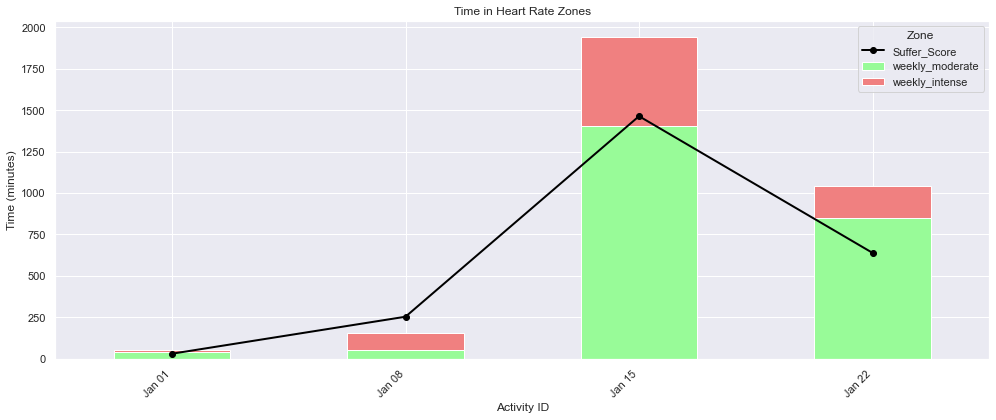

In [86]:
import matplotlib.pyplot as plt

ax = week_summary.plot(
    y=['weekly_moderate','weekly_intense'],
    x='week',
    kind='bar', 
    stacked=True, 
    figsize=(14, 6), 
    color=['#98FB98', '#F08080']
)

# Overlay line plot for 'weekly_suffer_score'
line = ax.plot(
    week_summary["week"],
    week_summary["weekly_suffer_score"],
    color="black",
    marker="o",
    linewidth=2,
    label="Suffer_Score"  
)

plt.title("Time in Heart Rate Zones")
plt.xlabel("Activity ID")
plt.ylabel("Time (minutes)")
plt.legend(title="Zone")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [74]:
# Melt the DataFrame to long format and plot
long_df = pd.melt(
    week_summary,
    id_vars="week",
    value_vars=["weekly_intense", "weekly_moderate"],
    var_name="zone",
    value_name="minutes"
)

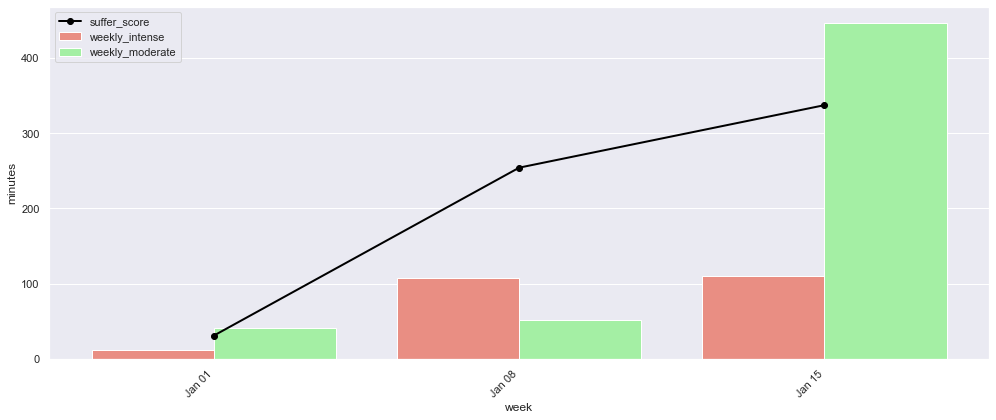

In [75]:
# Add a line plot on top 
plt.figure(figsize=(14, 6))
# Add line plot with a label
ax = sns.barplot(
    data=long_df,
    x="week",
    y="minutes",
    hue="zone",
    palette={"weekly_intense": "salmon", "weekly_moderate": "palegreen"}
)
line = ax.plot(
    week_summary["week"],
    week_summary["weekly_suffer_score"],
    color="black",
    marker="o",
    linewidth=2,
    label="suffer_score"  
)
# Create the legend manually from all handles
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

# Optional: improve layout
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.legend()
plt.show()

In [76]:
strava_df.head(1)

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score,time-minutes,average_speed,start_date
9,10569939382,"Tenerife D3 Santiago del Teide, coastal route ...",2024-01-16,Ride,45.8,3:55,11.6,5394.4,110.3,134.0,165.0,235.7,5.2,2024-01-16 10:19:21+00:00


In [77]:
strava_zone_df.head(1)

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score
9,10569939382,"Tenerife D3 Santiago del Teide, coastal route ...",2024-01-16,165.0,2024-01-16 10:19:21+00:00,34.2,133.7,67.8,0.0,0.0,167.9,67.8,2024-01-15,109.7,445.5,337.0


In [87]:
print(len(strava_df))
print(len(strava_zone_df))

14
14


In [88]:
# Save both
strava_df.to_pickle("strava_data_2024.pkl")
strava_zone_df.to_pickle("strava_zone_data_2024.pkl")

print("All data saved.")

All data saved.
